<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session8/Session_8_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is all about having a potent classifier for Cifar-10 dataset with the following considerations:
* Make this network: C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 cN is 1x1 Layer
* Keep the parameter count less than 50000
* Max Epochs is 20
* Use Batch Normalization

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00


## Helpers and Utils

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [ ]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [ ]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [ ]:
# downloading train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:10<00:00, 15877503.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [ ]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [ ]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

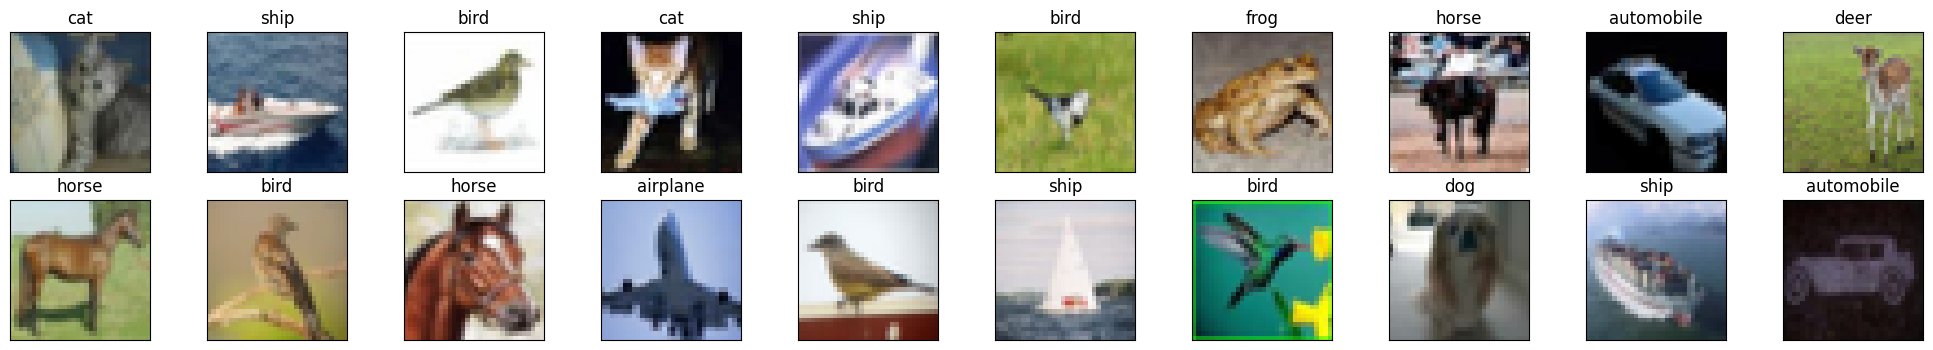

In [ ]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building and optimization

### Without dropouts and only BN

In [ ]:
class Cifar_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
        # add no relu or bn or DP
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [ ]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
# New Model Instance
baseline_model_1 = Cifar_Baseline(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]             528
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           4,640
      BatchNorm2d-12           [-1, 32, 12, 12]              64
             ReLU-13           [-1, 32, 12, 12]               0
           Conv2d-14           [-1, 32,

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 1.5003382725179042 Avg Train Metric: 0.3369614203148486: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


Function Took 23.9227 seconds


Avg Test Loss: 1.2133966450449787 Avg Test Metric: 0.5576925134357018: 100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Function Took 3.5147 seconds
Validation loss decreased (inf --> 1.213397).  Saving model ...
Epoch 1


Avg Train Loss: 1.0529675108697407 Avg Train Metric: 0.6078472715204634: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]


Function Took 19.5419 seconds


Avg Test Loss: 1.0405847332145595 Avg Test Metric: 0.6309776630582689: 100%|██████████| 79/79 [00:02<00:00, 29.08it/s]


Function Took 2.7253 seconds
Validation loss decreased (1.213397 --> 1.040585).  Saving model ...
Epoch 2


Avg Train Loss: 0.9102568380972919 Avg Train Metric: 0.6693292760178257: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Function Took 17.8184 seconds


Avg Test Loss: 0.9956112654903267 Avg Test Metric: 0.6448766242099714: 100%|██████████| 79/79 [00:02<00:00, 27.11it/s]


Function Took 2.9226 seconds
Validation loss decreased (1.040585 --> 0.995611).  Saving model ...
Epoch 3


Avg Train Loss: 0.8251096985834029 Avg Train Metric: 0.703057212140554: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]


Function Took 18.9373 seconds


Avg Test Loss: 0.8676465998722028 Avg Test Metric: 0.6990920101539998: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


Function Took 2.7664 seconds
Validation loss decreased (0.995611 --> 0.867647).  Saving model ...
Epoch 4


Avg Train Loss: 0.7689795742559311 Avg Train Metric: 0.7332801204508222: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


Function Took 20.0905 seconds


Avg Test Loss: 0.8176302117637441 Avg Test Metric: 0.7226063428045828: 100%|██████████| 79/79 [00:02<00:00, 28.30it/s]


Function Took 2.8007 seconds
Validation loss decreased (0.867647 --> 0.817630).  Saving model ...
Epoch 5


Avg Train Loss: 0.7236017368333724 Avg Train Metric: 0.7454627839195759: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s]


Function Took 18.7190 seconds


Avg Test Loss: 0.8122264056266109 Avg Test Metric: 0.7208742823781846: 100%|██████████| 79/79 [00:04<00:00, 18.55it/s]


Function Took 4.2653 seconds
Validation loss decreased (0.817630 --> 0.812226).  Saving model ...
Epoch 6


Avg Train Loss: 0.677949982683372 Avg Train Metric: 0.7611214331043955: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]


Function Took 18.0911 seconds


Avg Test Loss: 0.7951490509359143 Avg Test Metric: 0.7234177264986159: 100%|██████████| 79/79 [00:02<00:00, 28.05it/s]


Function Took 2.8265 seconds
Validation loss decreased (0.812226 --> 0.795149).  Saving model ...
Epoch 7


Avg Train Loss: 0.6507447363470521 Avg Train Metric: 0.7763185362376825: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s]


Function Took 18.7066 seconds


Avg Test Loss: 0.8136348543287832 Avg Test Metric: 0.7192573735985575: 100%|██████████| 79/79 [00:02<00:00, 29.04it/s]


Function Took 2.7264 seconds
EarlyStopping counter: 1 out of 3
Epoch 8


Avg Train Loss: 0.6210408650548257 Avg Train Metric: 0.7882807471258256: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Function Took 19.7215 seconds


Avg Test Loss: 0.8950009346008301 Avg Test Metric: 0.7030201184598706: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]


Function Took 2.8195 seconds
EarlyStopping counter: 2 out of 3
Epoch 9


Avg Train Loss: 0.5971528650702113 Avg Train Metric: 0.7928803555495904: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]


Function Took 18.2601 seconds


Avg Test Loss: 0.8221549482285222 Avg Test Metric: 0.726893559286866: 100%|██████████| 79/79 [00:03<00:00, 22.06it/s]

Function Took 3.5935 seconds
EarlyStopping counter: 3 out of 3
Early stopping


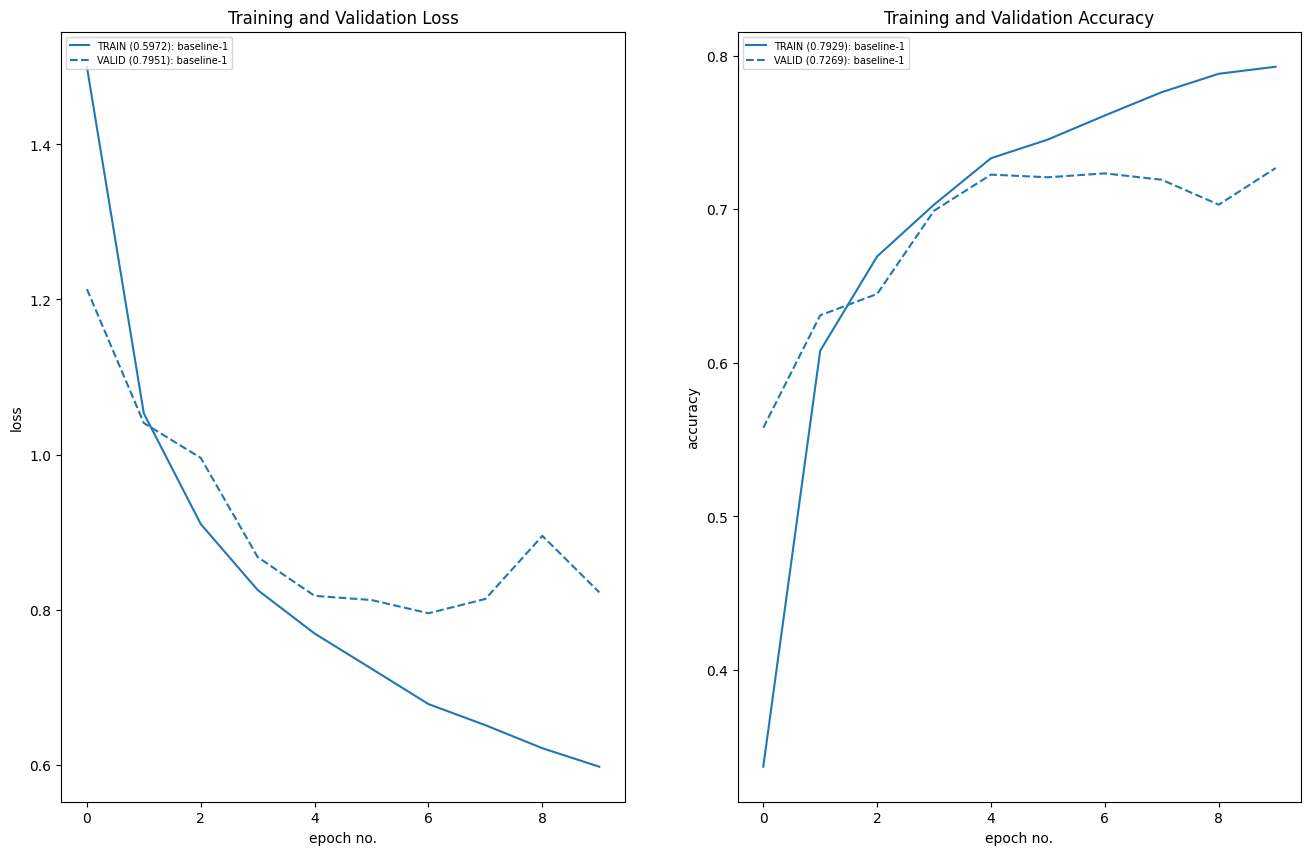

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

### Adding dropouts

In [ ]:
class Cifar_Baseline_DP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44

    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model_2 = Cifar_Baseline_DP(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             528
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
        MaxPool2d-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 32, 12, 12]           4,640
      BatchNorm2d-14           [-1, 32,

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_2, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 1.6493665175059873 Avg Train Metric: 0.27946842698108815: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]


Function Took 19.3364 seconds


Avg Test Loss: 1.4716828216480304 Avg Test Metric: 0.45773778874662857: 100%|██████████| 79/79 [00:02<00:00, 28.44it/s]


Function Took 2.7873 seconds
Validation loss decreased (inf --> 1.471683).  Saving model ...
Epoch 1


Avg Train Loss: 1.2309213577938811 Avg Train Metric: 0.5324643083545558: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]


Function Took 19.5695 seconds


Avg Test Loss: 1.1277772972855387 Avg Test Metric: 0.5962891307058213: 100%|██████████| 79/79 [00:02<00:00, 27.70it/s]


Function Took 2.8584 seconds
Validation loss decreased (1.471683 --> 1.127777).  Saving model ...
Epoch 2


Avg Train Loss: 1.07799957383929 Avg Train Metric: 0.6096410595852396: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]


Function Took 19.7406 seconds


Avg Test Loss: 1.0978172119659713 Avg Test Metric: 0.6046838669837276: 100%|██████████| 79/79 [00:02<00:00, 28.90it/s]


Function Took 2.7421 seconds
Validation loss decreased (1.127777 --> 1.097817).  Saving model ...
Epoch 3


Avg Train Loss: 0.9933140611709537 Avg Train Metric: 0.6467541451649288: 100%|██████████| 391/391 [00:20<00:00, 19.14it/s]


Function Took 20.4414 seconds


Avg Test Loss: 1.1044132121001617 Avg Test Metric: 0.625517768950402: 100%|██████████| 79/79 [00:03<00:00, 25.93it/s]


Function Took 3.0537 seconds
EarlyStopping counter: 1 out of 3
Epoch 4


Avg Train Loss: 0.9282228109781699 Avg Train Metric: 0.6682150502643927: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]


Function Took 18.3684 seconds


Avg Test Loss: 0.9595468481884727 Avg Test Metric: 0.6669418253476107: 100%|██████████| 79/79 [00:03<00:00, 25.32it/s]


Function Took 3.1296 seconds
Validation loss decreased (1.097817 --> 0.959547).  Saving model ...
Epoch 5


Avg Train Loss: 0.8826337715853816 Avg Train Metric: 0.6894441958888412: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]


Function Took 19.4210 seconds


Avg Test Loss: 0.8514672464962247 Avg Test Metric: 0.7004839234714266: 100%|██████████| 79/79 [00:02<00:00, 27.41it/s]


Function Took 2.8928 seconds
Validation loss decreased (0.959547 --> 0.851467).  Saving model ...
Epoch 6


Avg Train Loss: 0.8437333186264233 Avg Train Metric: 0.7039730042752708: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]


Function Took 19.6422 seconds


Avg Test Loss: 0.896607973153078 Avg Test Metric: 0.6930792927742004: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


Function Took 2.8530 seconds
EarlyStopping counter: 1 out of 3
Epoch 7


Avg Train Loss: 0.815810723225479 Avg Train Metric: 0.7110144221569266: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]


Function Took 19.1611 seconds


Avg Test Loss: 0.8645604886586153 Avg Test Metric: 0.6999202861061579: 100%|██████████| 79/79 [00:03<00:00, 25.41it/s]


Function Took 3.1158 seconds
EarlyStopping counter: 2 out of 3
Epoch 8


Avg Train Loss: 0.7901245067491556 Avg Train Metric: 0.7214778408674938: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]


Function Took 18.5603 seconds


Avg Test Loss: 0.8357225347168838 Avg Test Metric: 0.7119751119915443: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s]


Function Took 3.0588 seconds
Validation loss decreased (0.851467 --> 0.835723).  Saving model ...
Epoch 9


Avg Train Loss: 0.7667731709797364 Avg Train Metric: 0.7328494200316231: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]


Function Took 19.1750 seconds


Avg Test Loss: 0.7913357185412057 Avg Test Metric: 0.72030990108659: 100%|██████████| 79/79 [00:02<00:00, 28.99it/s]


Function Took 2.7377 seconds
Validation loss decreased (0.835723 --> 0.791336).  Saving model ...
Epoch 10


Avg Train Loss: 0.7459859250451598 Avg Train Metric: 0.7401558404688335: 100%|██████████| 391/391 [00:20<00:00, 19.44it/s]


Function Took 20.1176 seconds


Avg Test Loss: 0.7676357898531081 Avg Test Metric: 0.7291885229605662: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


Function Took 2.8328 seconds
Validation loss decreased (0.791336 --> 0.767636).  Saving model ...
Epoch 11


Avg Train Loss: 0.7347851990129027 Avg Train Metric: 0.7448690280585033: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s]


Function Took 18.7333 seconds


Avg Test Loss: 0.7611532716811458 Avg Test Metric: 0.7489288698268842: 100%|██████████| 79/79 [00:03<00:00, 24.72it/s]


Function Took 3.2016 seconds
Validation loss decreased (0.767636 --> 0.761153).  Saving model ...
Epoch 12


Avg Train Loss: 0.7200110729240701 Avg Train Metric: 0.7514772171254658: 100%|██████████| 391/391 [00:18<00:00, 21.22it/s]


Function Took 18.4365 seconds


Avg Test Loss: 0.7413480689253988 Avg Test Metric: 0.7411344232438486: 100%|██████████| 79/79 [00:02<00:00, 26.76it/s]


Function Took 2.9632 seconds
Validation loss decreased (0.761153 --> 0.741348).  Saving model ...
Epoch 13


Avg Train Loss: 0.7092060507715815 Avg Train Metric: 0.7535364508933728: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]


Function Took 19.1980 seconds


Avg Test Loss: 0.7359993646416483 Avg Test Metric: 0.7375547893439667: 100%|██████████| 79/79 [00:02<00:00, 28.61it/s]


Function Took 2.7709 seconds
Validation loss decreased (0.741348 --> 0.735999).  Saving model ...
Epoch 14


Avg Train Loss: 0.701836223492537 Avg Train Metric: 0.7596764314510024: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]


Function Took 19.3418 seconds


Avg Test Loss: 0.7502003828935986 Avg Test Metric: 0.7334589958190918: 100%|██████████| 79/79 [00:02<00:00, 29.33it/s]


Function Took 2.7026 seconds
EarlyStopping counter: 1 out of 3
Epoch 15


Avg Train Loss: 0.6886688983044051 Avg Train Metric: 0.7617070211473939: 100%|██████████| 391/391 [00:18<00:00, 21.25it/s]


Function Took 18.4110 seconds


Avg Test Loss: 0.8273079259486138 Avg Test Metric: 0.7258437939837009: 100%|██████████| 79/79 [00:03<00:00, 21.54it/s]


Function Took 3.6760 seconds
EarlyStopping counter: 2 out of 3
Epoch 16


Avg Train Loss: 0.6822682385097074 Avg Train Metric: 0.7609038203573593: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]


Function Took 18.9312 seconds


Avg Test Loss: 0.7166524793528304 Avg Test Metric: 0.756473936612093: 100%|██████████| 79/79 [00:02<00:00, 28.34it/s]


Function Took 2.7954 seconds
Validation loss decreased (0.735999 --> 0.716652).  Saving model ...
Epoch 17


Avg Train Loss: 0.668133826893004 Avg Train Metric: 0.7659717990309381: 100%|██████████| 391/391 [00:20<00:00, 19.28it/s]


Function Took 20.2828 seconds


Avg Test Loss: 0.7185234827331349 Avg Test Metric: 0.7510410192646558: 100%|██████████| 79/79 [00:02<00:00, 26.81it/s]


Function Took 2.9559 seconds
EarlyStopping counter: 1 out of 3
Epoch 18


Avg Train Loss: 0.6628145809521151 Avg Train Metric: 0.7704806131170229: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]


Function Took 19.9971 seconds


Avg Test Loss: 0.7175584009176568 Avg Test Metric: 0.7515675531157965: 100%|██████████| 79/79 [00:02<00:00, 27.24it/s]


Function Took 2.9131 seconds
EarlyStopping counter: 2 out of 3
Epoch 19


Avg Train Loss: 0.6523512766489288 Avg Train Metric: 0.7774669218551168: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]


Function Took 18.7388 seconds


Avg Test Loss: 0.728584660759455 Avg Test Metric: 0.7639399231234684: 100%|██████████| 79/79 [00:03<00:00, 22.15it/s]

Function Took 3.5782 seconds
EarlyStopping counter: 3 out of 3
Early stopping


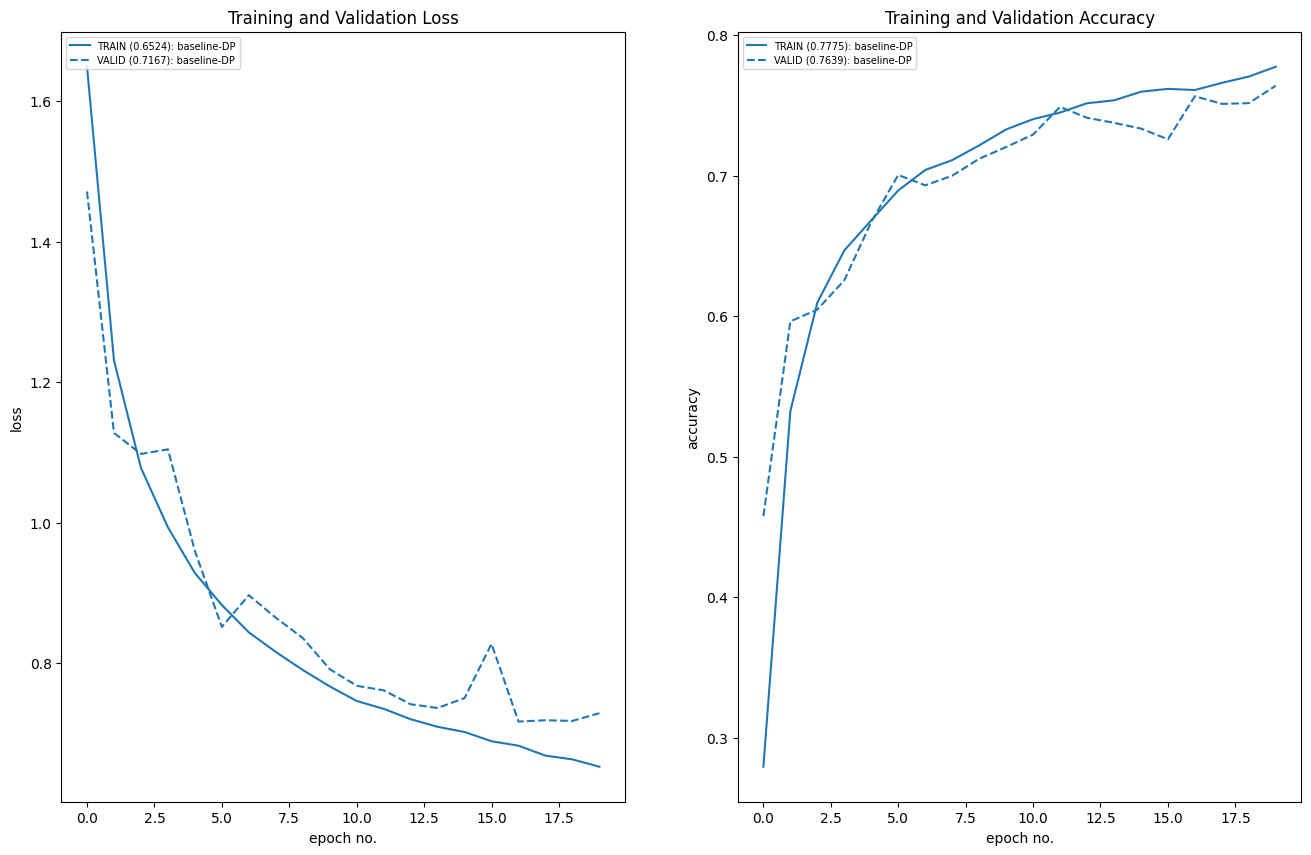

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-DP'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

## Eval Framework and Metrics

In [ ]:
def eval_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                ):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  predictions = []
  actuals = []

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      actuals.append(label)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      # metric calc
      preds = torch.argmax(preds,dim=1)

      predictions.append(preds)

  return torch.cat(actuals, dim=0).cpu().numpy(), torch.cat(predictions, dim=0).cpu().numpy()

In [ ]:
eval_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
actuals , predictions = eval_module(baseline_model_2, device, eval_loader)

100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


In [ ]:
min(actuals),max(actuals)

(0, 9)

## Metrics

In [ ]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.81      0.77      0.79      1000
  automobile       0.93      0.82      0.87      1000
        bird       0.69      0.63      0.66      1000
         cat       0.53      0.59      0.56      1000
        deer       0.74      0.74      0.74      1000
         dog       0.58      0.77      0.66      1000
        frog       0.78      0.83      0.80      1000
       horse       0.85      0.71      0.78      1000
        ship       0.86      0.85      0.86      1000
       truck       0.88      0.83      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.77      0.75      0.76     10000



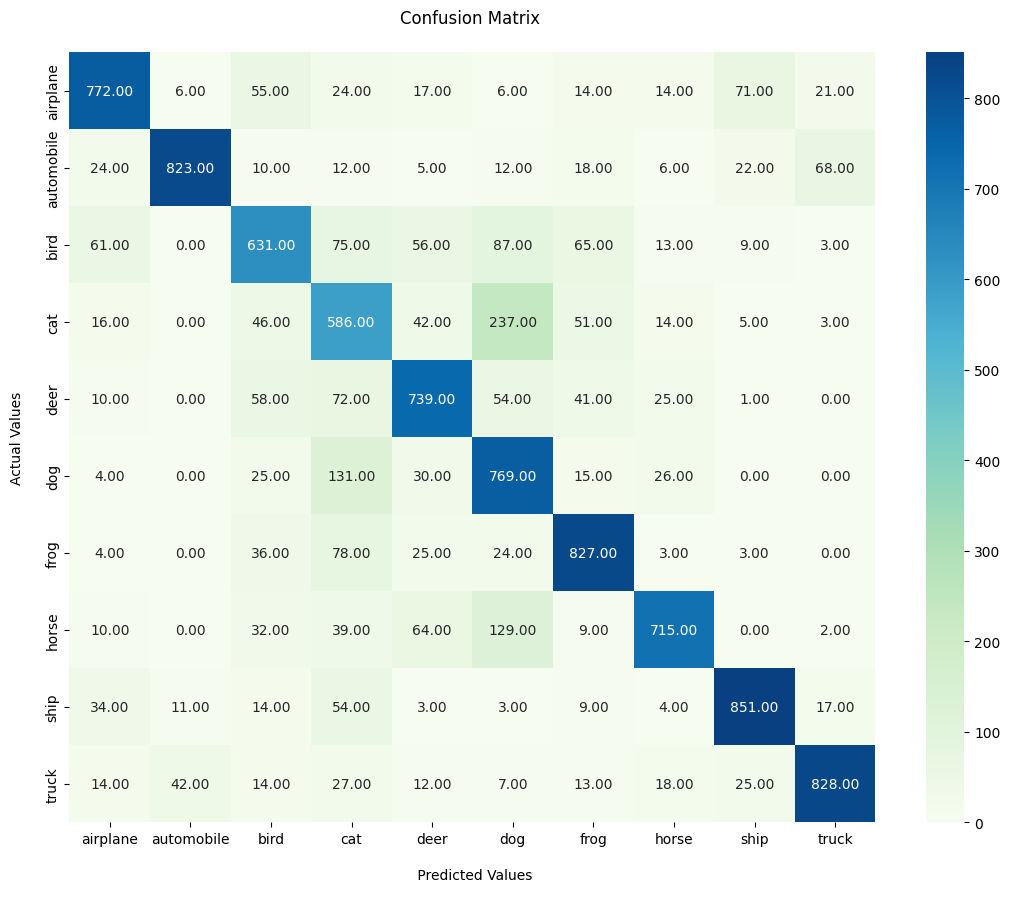

In [ ]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [ ]:
mismatches = np.where(predictions != actuals)

In [ ]:
# idx = mismatches[0][0]
# print(f'Actual: {classes[actuals[idx]]}')
# print(f'Predicted: {classes[predictions[idx]]}')

Label: airplane and Prediction: ship


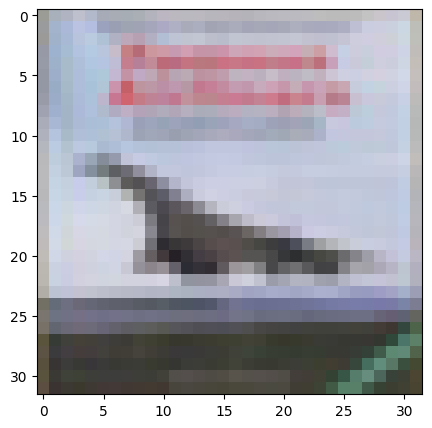

Label: frog and Prediction: dog


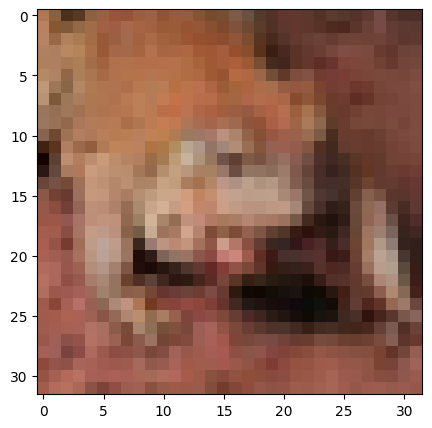

Label: automobile and Prediction: truck


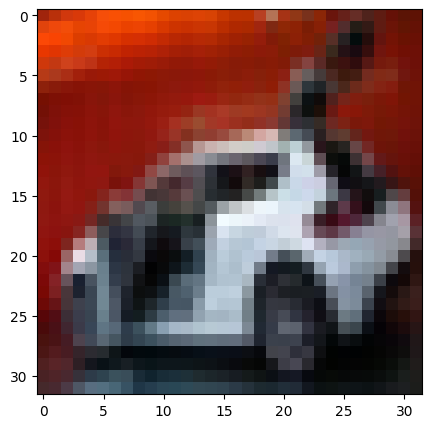

Label: frog and Prediction: bird


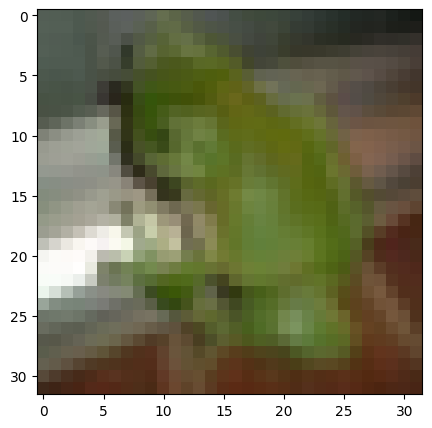

Label: automobile and Prediction: truck


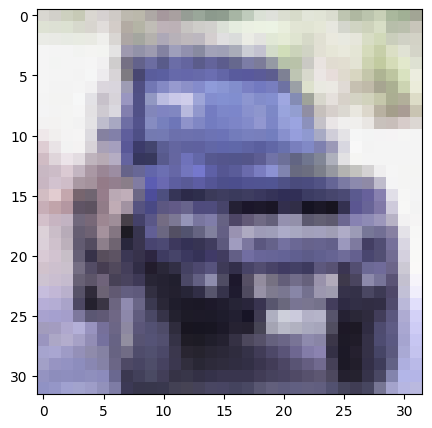

Label: airplane and Prediction: bird


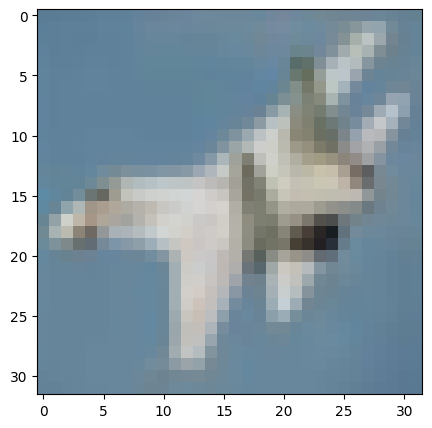

Label: dog and Prediction: deer


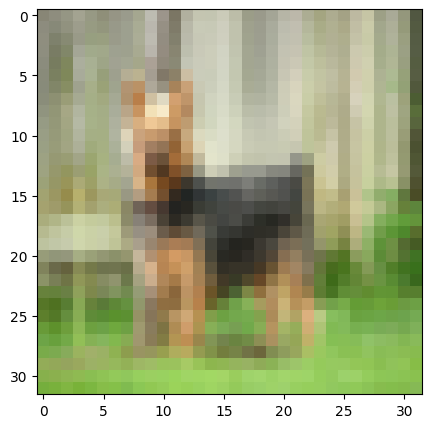

Label: deer and Prediction: frog


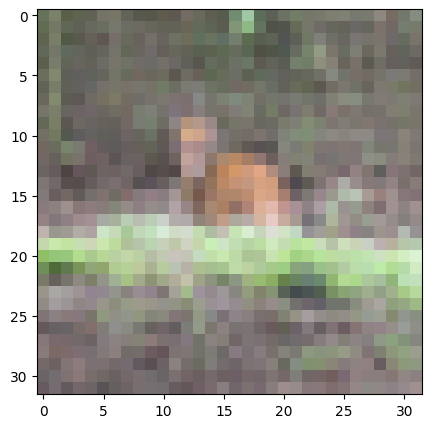

Label: bird and Prediction: cat


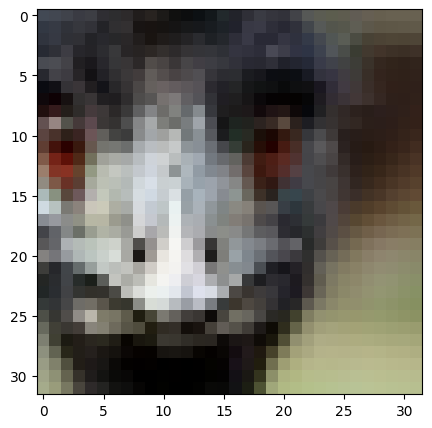

Label: automobile and Prediction: truck


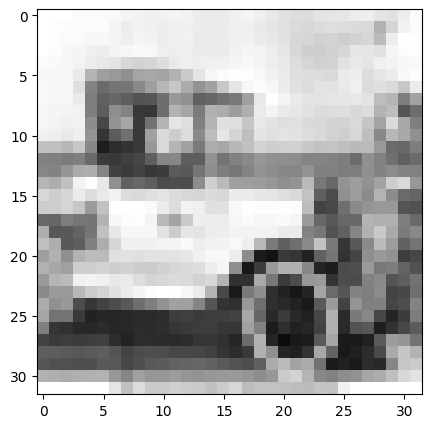

In [ ]:
for idx in mismatches[0][:10]:
  plt.figure(figsize=(5,5))
  img, label = test[idx]
  imshow(img)
  print(f'Label: {classes[label]} and Prediction: {classes[predictions[idx]]}')
  plt.show()

Sumamry:

- The model used is a Cifar_Baseline, which is a convolutional neural network with three convolution blocks, each followed by a transition block.
- The model achieved a training accuracy of 76% and a validation accuracy of 76%.
- The model's training loss was 0.67 and its validation loss was 0.67.
- The model's confusion matrix showed that it was most accurate at classifying Autombile and least accurate at classifying Cats.
- Early stopping was triggered after 14 epochs due to lack of improvement in validation loss.
- Addition of Dropouts makes a significant difference in terms of overfitting.

## Links:
https://medium.com/@zljdanceholic/groupnorm-then-batchnorm-instancenorm-layernorm-e2b2a1d350a0
https://wandb.ai/wandb_fc/Normalization/reports/Normalization-Series-What-is-Batch-Norm---VmlldzoxMjk2ODcz
https://wandb.ai/wandb_fc/GroupNorm/reports/Group-Normalization-in-Pytorch-With-Examples---VmlldzoxMzU0MzMy
https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
https://wandb.ai/wandb_fc/Normalization-Series/reports/Instance-Normalization-in-PyTorch-With-Examples---VmlldzoxNDIyNTQx